In [2]:
from random import random
import random as rd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from sklearn.cluster import MeanShift, estimate_bandwidth
from skimage import img_as_ubyte
from skimage.color import label2rgb

## Graph-Based Algorithm

Creating Classes to store and process Images as graphs.

In [3]:
class Pixel:
    def __init__(self, parent, rank = 0, size = 1):
        self.parent = parent
        self.rank = rank
        self.size = size

class Image_Graph:
    def __init__(self, num_pixels):
        self.nodes = [Pixel(i) for i in range(num_pixels)]
        self.num_sets = num_pixels # initially each pixel is in its own set
    
    def size_of(self, i):
        return self.nodes[i].size

    def find(self, n):
        temp = n
        while temp!=self.nodes[temp].parent:
            temp = self.nodes[temp].parent
        
        self.nodes[n].parent = temp
        return temp
    

    def merge(self, a, b):
        if self.nodes[a].rank > self.nodes[b].rank:
            self.nodes[b].parent = a
            self.nodes[a].size = self.nodes[a].size + self.nodes[b].size
        else:
            self.nodes[a].parent = b
            self.nodes[b].size = self.nodes[b].size + self.nodes[a].size

            if self.nodes[a].rank == self.nodes[b].rank:
                self.nodes[b].rank = self.nodes[b].rank + 1
            
            self.num_sets = self.num_sets - 1

Functions to create a graph, given an Image.

In [4]:
def create_edge(img, width, x, y, x1, y1, diff):
    vertex_id = lambda x,y : y * width + x
    w = diff(img, x, y, x1, y1)
    return (vertex_id(x,y), vertex_id(x1,y1), w)

def build_graph(img, width, height, diff, neighborhood_8=False):
    graph_edges = []
    for y in range(height):
        for x in range(width):
            if x > 0:
                graph_edges.append(create_edge(img, width, x, y, x-1, y, diff))

            if y > 0:
                graph_edges.append(create_edge(img, width, x, y, x, y-1, diff))

            if neighborhood_8:
                if x > 0 and y > 0:
                    graph_edges.append(create_edge(img, width, x, y, x-1, y-1, diff))

                if x > 0 and y < height-1:
                    graph_edges.append(create_edge(img, width, x, y, x-1, y+1, diff))

    return graph_edges

def remove_small_components(forest, graph, min_size):
    for edge in graph:
        a = forest.find(edge[0])
        b = forest.find(edge[1])

        if a != b and (forest.size_of(a) < min_size or forest.size_of(b) < min_size):
            forest.merge(a, b)
    
    return forest

def segment_graph(graph_edges, num_nodes, const, min_size, threshold_func):
    # Step 1: initialization
    forest = Image_Graph(num_nodes)
    weight = lambda edge: edge[2]
    sorted_graph = sorted(graph_edges, key=weight)
    threshold = [ threshold_func(1, const) for _ in range(num_nodes) ]

    # Step 2: merging
    for edge in sorted_graph:
        parent_a = forest.find(edge[0])
        parent_b = forest.find(edge[1])
        a_condition = weight(edge) <= threshold[parent_a]
        b_condition = weight(edge) <= threshold[parent_b]

        if parent_a != parent_b and a_condition and b_condition:
            forest.merge(parent_a, parent_b)
            a = forest.find(parent_a)
            threshold[a] = weight(edge) + threshold_func(forest.nodes[a].size, const)

    return remove_small_components(forest, sorted_graph, min_size)
    # return forest


In [5]:
rd.seed(42)

Functions to calculate internal difference of components, Threshold value, and generate image from a given graph.

In [6]:

def diff(img, x1, y1, x2, y2):
    _out = np.sum((img[x1, y1] - img[x2, y2]) ** 2)
    return np.sqrt(_out)


def threshold(size, const):
    return (const / size)


def generate_image(forest, width, height):
    random_color = lambda: (int(random()*255), int(random()*255), int(random()*255))
    colors = [random_color() for i in range(width*height)]

    img = Image.new('RGB', (width, height))
    im = img.load()
    for y in range(height):
        for x in range(width):
            comp = forest.find(y * width + x)
            im[x, y] = colors[comp]

    return img.transpose(Image.ROTATE_270).transpose(Image.FLIP_LEFT_RIGHT)

Function to process Image and return the segmented image.

In [7]:
def get_segmented_image(sigma, neighbour, K, min_comp_size, im):

    size = im.shape
    # smooth = cv2.GaussianBlur(im,(5,5), sigma)
    smooth = np.array(im).astype(int)

    graph_edges = build_graph(smooth, size[0], size[1], diff, neighbour==8)

    forest = segment_graph(graph_edges, size[0]*size[1], K, min_comp_size, threshold)

    seg_image = generate_image(forest, size[0], size[1])

    return np.array(seg_image)
    

## Meanshift Segmentation

Function to get Mean shift segmentation of an image.

In [8]:
from sklearn.cluster import MeanShift, estimate_bandwidth

def get_meanshift_seg(im):
    v = np.float32(im.reshape((-1, 3)))

    bandwidth = estimate_bandwidth(v, quantile=.10, n_samples=2000)
    model = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    labels = model.fit_predict(v)
    im_labels = labels.reshape(im.shape[:2])
    im_labels = img_as_ubyte(label2rgb(im_labels))
    return im_labels

## Remove Background Function

Function to remove background from an image and return the binary mask.

In [9]:
## Referred from below link
## https://www.geeksforgeeks.org/image-segmentation-with-watershed-algorithm-opencv-python/?ref=lbp

def remove_background(im):
    im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    #im_gray = im
    ret, thresh = cv2.threshold(im_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = np.ones((3,3), np.uint8)
    morph_op = cv2.morphologyEx(thresh, cv2.MORPH_OPEN,
                            kernel, iterations=3)

    bg = cv2.dilate(morph_op, kernel, iterations=2)
    return bg

## Algorithms

In [10]:
# Only Efficient Graph based Segmentation
def Seg_Iter_1(im):
    segmented_image = get_segmented_image(0.8, 8, 300, 4000,im)

    return segmented_image

In [11]:
# Graph Based Segmentation with Meanshift
def Seg_Iter_2(im):
    ms_image = get_meanshift_seg(im)
    segmented_image = get_segmented_image(0.8, 8, 300, 4000,ms_image)

    return segmented_image

In [12]:
# Graph based Segmentation with Meanshift and Addition of Background mask on final image
def Seg_Iter_3(im):
    bg = remove_background(im)
    ms_image = get_meanshift_seg(im)
    segmented_image = get_segmented_image(0.8, 8, 300, 4000,ms_image)
    foreground_image = cv2.bitwise_and(segmented_image, segmented_image, mask=bg)
    
    return foreground_image

## MIoU Calculation

In [13]:
def calc_IoU(gt_image, pred_image):
    intersection = np.bitwise_and(pred_image, gt_image)
    union = np.bitwise_or(pred_image, gt_image)
    iou = np.sum(intersection) / np.sum(union)

    return iou

In [14]:
def get_segment_list(im):
    size = im.shape
    # print(f'size: {size}')
    segment = {}
    k = 0
    for i in range(size[0]):
        for j in range(size[1]):
            if im[i][j] in segment:
                im[i][j] = segment[im[i][j]]
            else:
                segment[im[i][j]] = k
                im[i][j] = k
                k += 1

    return im

In [15]:
def calc_mean_IoU(gt_image, pred_image):
    gt_image = cv2.cvtColor(gt_image, cv2.COLOR_BGR2GRAY)
    gt_seg = get_segment_list(gt_image)
    pred_image = cv2.cvtColor(pred_image, cv2.COLOR_BGR2GRAY)
    # print(f'print image shape: {pred_image.shape}')
    # print(f'gt image shape: {gt_image.shape}')
    pred_seg = get_segment_list(pred_image)

    iou = 0
    for i in ((np.unique(pred_seg))):
        pred_mask = pred_seg == i
        curr_pred_iou = 0
        for j in (np.unique(gt_seg)):
            gt_mask = gt_seg == j
            curr_iou = calc_IoU(gt_mask, pred_mask)

            if curr_iou > curr_pred_iou:
                curr_pred_iou = curr_iou
        
        iou = iou + curr_pred_iou

    mean_iou = iou / len(np.unique(pred_seg))

    return mean_iou


## Algorithm Implementation on Sample Images

In [19]:
# Importing Sample Images, Use any 1 of the below


im = cv2.imread('./Assignment Dataset/Assignment Dataset/Images/img_dir/00000263.jpg', cv2.IMREAD_COLOR)
gt_im = cv2.imread('./Assignment Dataset/Assignment Dataset/Images/ann_dir/00000263.png',cv2.IMREAD_COLOR)

# im = cv2.imread('./Assignment Dataset/Assignment Dataset/Images/img_dir/00004551.jpg', cv2.IMREAD_COLOR)
# gt_im = cv2.imread('./Assignment Dataset/Assignment Dataset/Images/ann_dir/00004551.png',cv2.IMREAD_COLOR)

# im = cv2.imread('./Assignment Dataset/Assignment Dataset/Images/img_dir/00004439.jpg', cv2.IMREAD_COLOR)
# gt_im = cv2.imread('./Assignment Dataset/Assignment Dataset/Images/ann_dir/00004439.png',cv2.IMREAD_COLOR)

# im = cv2.imread('./Assignment Dataset/Assignment Dataset/Images/img_dir/00004795.jpg', cv2.IMREAD_COLOR)
# gt_im = cv2.imread('./Assignment Dataset/Assignment Dataset/Images/ann_dir/00006110.png',cv2.IMREAD_COLOR)

# im = cv2.imread('./Assignment Dataset/Assignment Dataset/Images/img_dir/00006110.jpg', cv2.IMREAD_COLOR)
# gt_im = cv2.imread('./Assignment Dataset/Assignment Dataset/Images/ann_dir/00006110.png',cv2.IMREAD_COLOR)

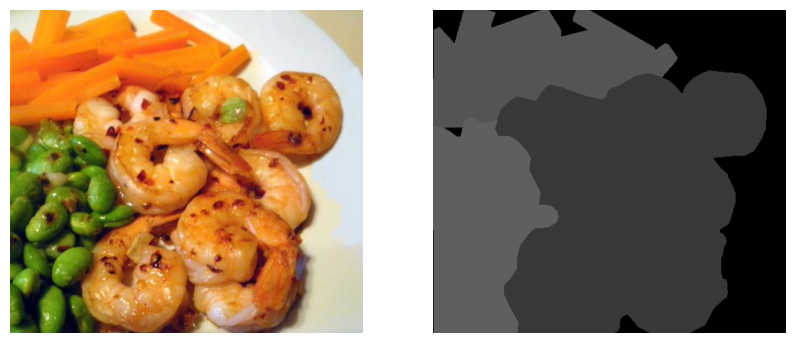

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(10, 8))


axs[0].imshow(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))
axs[0].axis('off')  

axs[1].imshow(gt_im)
axs[1].axis('off')

plt.show()

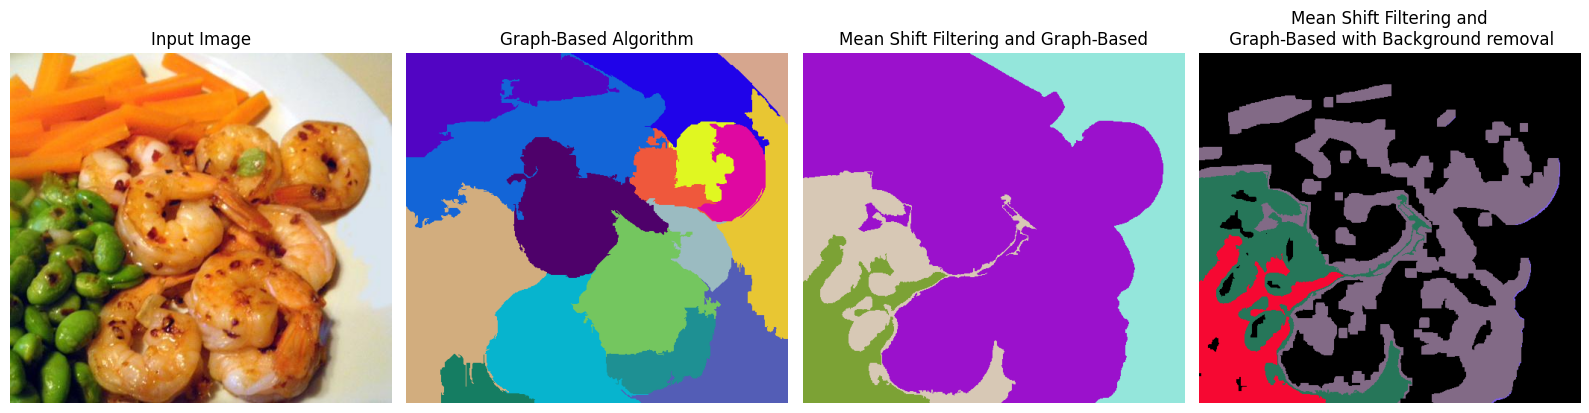

In [21]:
# Generating Segmentation from each Algorithm

Algo_1_op = Seg_Iter_1(im)
Algo_2_op = Seg_Iter_2(im)
Algo_3_op = Seg_Iter_3(im)



# Displaying Results

fig, axs = plt.subplots(1, 4, figsize=(16, 8))

# Display the first image on the first subplot
axs[0].imshow(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))
axs[0].set_title('Input Image')
axs[0].axis('off')  # Turn off axis labels

axs[1].imshow(Algo_1_op)
axs[1].set_title('Graph-Based Algorithm')
axs[1].axis('off')


axs[2].imshow(Algo_2_op)
axs[2].set_title('Mean Shift Filtering and Graph-Based')
axs[2].axis('off')  # Turn off axis labels


axs[3].imshow(Algo_3_op)
axs[3].set_title('Mean Shift Filtering and\n Graph-Based with Background removal')
axs[3].axis('off')  # Turn off axis labels

plt.tight_layout()

plt.show()


In [48]:
MIoU_1 = calc_mean_IoU(gt_im, Algo_1_op)
MIoU_2 = calc_mean_IoU(gt_im, Algo_2_op)
MIoU_3 = calc_mean_IoU(gt_im, Algo_3_op)

print(f"Efficient Graph Based Algorithm MIoU score : \t\t\t\t\t\t{MIoU_1}")
print(f"Mean Shift Filter and Efficient Graph Based Algorithm MIoU score : \t\t\t{MIoU_2}")
print(f"Mean Shift Filter and Efficient Graph Based Algorithm with Background removal MIoU score : {MIoU_3}")

Efficient Graph Based Algorithm MIoU score : 						0.20664687132890752
Mean Shift Filter and Efficient Graph Based Algorithm MIoU score : 			0.3146800776711413
Mean Shift Filter and Efficient Graph Based Algorithm with Background removal MIoU score : 0.22597106835167283


## Evaluation on Dataset

In [263]:
import os
import cv2
import numpy as np
import time

# Specify the path to the directory containing your images
im_directory_path = "./Assignment Dataset/Assignment Dataset/Images/img_dir/"
gt_directory_path = "./Assignment Dataset/Assignment Dataset/Images/ann_dir/"
# Get a list of all files in the directory
file_list = os.listdir(im_directory_path)
gt_file_list = os.listdir(gt_directory_path)
# Initialize an empty list to store the MIoU scores
MIoU_1_list = []
MIoU_2_list = []
MIoU_3_list = []

start_time = time.time()
# Loop through each file in the directory
for current_image, true_image in zip(file_list, gt_file_list) :
    # Construct the full file path
    current_im_path = os.path.join(im_directory_path, current_image)
    true_im_path = os.path.join(gt_directory_path,true_image)
    # Read the image using OpenCV
    curr_image = cv2.imread(current_im_path)
    gt_image = cv2.imread(true_im_path)


    Algo_1_op = Seg_Iter_1(curr_image)
    Algo_2_op = Seg_Iter_2(curr_image)
    Algo_3_op = Seg_Iter_3(curr_image)
    

    MIoU_1 = calc_mean_IoU(gt_image, Algo_1_op)
    MIoU_2 = calc_mean_IoU(gt_image, Algo_2_op)
    MIoU_3 = calc_mean_IoU(gt_image, Algo_3_op)

    MIoU_1_list.append(MIoU_1)
    MIoU_2_list.append(MIoU_2)
    MIoU_3_list.append(MIoU_3)

    time_elapsed = time.time() - start_time

    if time_elapsed >= 46800:
        print(f'{time_elapsed} seconds passed. Exiting....')
        break

print(f'No. of Images Processed : {len(MIoU_1_list)}')


46887.01364970207 seconds passed. Exiting....
No. of Images Processed : 908


In [395]:
MIou_avg_1 = np.mean(MIoU_1_list)
MIou_avg_2 = np.mean(MIoU_2_list)
MIou_avg_3 = np.mean(MIoU_3_list)

print(f"Average MIoU of Algorithm 1 on dataset : {MIou_avg_1}")
print(f"Average MIoU of Algorithm 2 on dataset : {MIou_avg_2}")
print(f"Average MIoU of Algorithm 3 on dataset : {MIou_avg_3}")

Average MIoU of Algorithm 1 on dataset : 0.22632483129957823
Average MIoU of Algorithm 2 on dataset : 0.3414414429842025
Average MIoU of Algorithm 3 on dataset : 0.2572074716466211


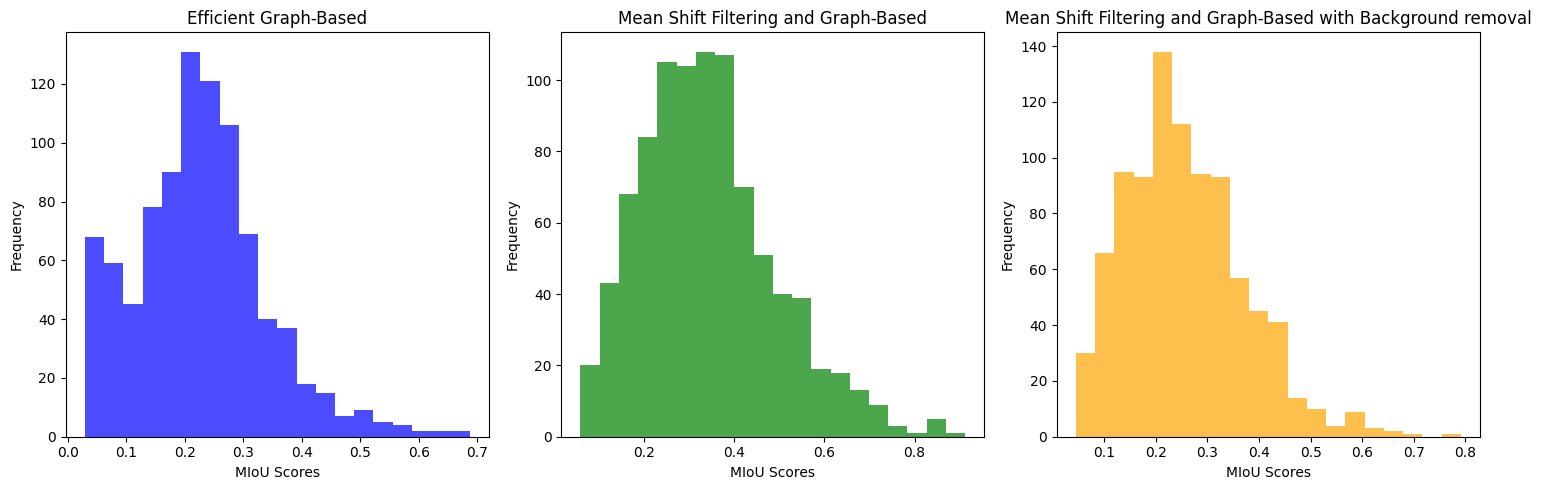

In [396]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot histogram for accuracy_scores_1
axes[0].hist(MIoU_1_list, bins=20, color='blue', alpha=0.7)
axes[0].set_title('Efficient Graph-Based')
axes[0].set_xlabel('MIoU Scores')
axes[0].set_ylabel('Frequency')

# Plot histogram for accuracy_scores_2
axes[1].hist(MIoU_2_list, bins=20, color='green', alpha=0.7)
axes[1].set_title('Mean Shift Filtering and Graph-Based')
axes[1].set_xlabel('MIoU Scores')
axes[1].set_ylabel('Frequency')

# Plot histogram for accuracy_scores_3
axes[2].hist(MIoU_3_list, bins=20, color='orange', alpha=0.7)
axes[2].set_title('Mean Shift Filtering and Graph-Based with Background removal')
axes[2].set_xlabel('MIoU Scores')
axes[2].set_ylabel('Frequency')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()